### Описание проекта

<br/><br/>
Это учебный проект Яндекс.Практикума. В конце проверяем несколько гипотез с помощью ttest_ind.

Анализируем данные вымышленной компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

Важное: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных  
<br/><br/>
**Таблица users (информация о пользователях):** 
   
user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана

<br/><br/>
**Таблица calls (информация о звонках):**

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

<br/><br/>
**Таблица messages (информация о сообщениях):**

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

<br/><br/>
**Таблица internet (информация об интернет-сессиях):**

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

<br/><br/>
**Таблица tariffs (информация о тарифах):**

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Знакомство с данными и их подготовка



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import matplotlib.pyplot as plt

df1 = pd.read_csv('/datasets/calls.csv')
df2 = pd.read_csv('/datasets/internet.csv')
df3 = pd.read_csv('/datasets/messages.csv')
df4 = pd.read_csv('/datasets/tariffs.csv')
df5 = pd.read_csv('/datasets/users.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184


Количество дубликатов: 0
Количество звонков с нулевой длительностью: 39613


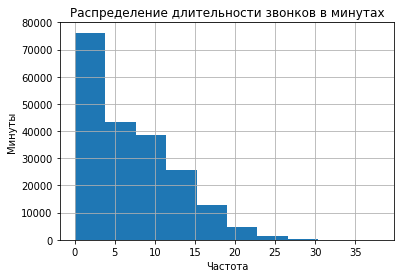

In [ ]:
plt.title('Распределение длительности звонков в минутах')
plt.xlabel('Частота')
plt.ylabel('Минуты')

display(df1.info())
display(df1.sample(5,random_state=42))
print(f'Количество дубликатов: {df1.duplicated().sum()}')
print('Количество звонков с нулевой длительностью: {}'.format(df1[df1['duration'] == 0.0]['duration'].count()))
df1['duration'].hist();

В таблице 'calls' нет пропущенных значений и дубликатов. В столбце duration 39613 записей с нулевым количеством минут. Удалим их, потому что это либо пропущенные звонки, либо исходящие, которые не тарифицируются и будут искажать расчеты.

In [ ]:
df1['call_date'] = pd.to_datetime(df1['call_date'], format='%Y-%m-%d')
df1['duration'] = df1['duration'].apply(np.ceil)
df1 = df1[df1.duration != 0]
display(df1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

Поменяли формат столбца 'call_date' с object на datetime64, удалили строки с продолжительностью звонков, равных нулю.

In [ ]:
display(df2.info())
display(df2.sample(5,random_state=42))
print(df2.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
31737,31737,1110_331,351.71,2018-09-04,1110
31333,31333,1109_399,257.69,2018-06-09,1109
61121,61121,1207_191,128.18,2018-11-05,1207
71184,71184,1241_88,736.71,2018-11-23,1241
84394,84394,1286_76,900.69,2018-12-18,1286


0


Нет пропущенных значений и дубликатов. Нужно поменять тип данных в session_date, удалить столбец Unnamed: 0, где находятся дубликаты индекса.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
Количество дубликатов: 0
Количество сессий, где потрачено 0 мегабайт: 19598


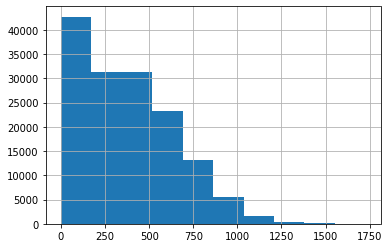

In [ ]:
df2 = df2.drop(columns=['Unnamed: 0'])
df2['session_date'] = pd.to_datetime(df2['session_date'], format='%Y-%m-%d')
df2.info();
print(f'Количество дубликатов: {df2.duplicated().sum()}')
print('Количество сессий, где потрачено 0 мегабайт: {}'.format(df2[df2['mb_used'] == 0.0]['mb_used'].count()))
df2.mb_used.hist();

Поменяли тип данных session_date на datetime64, удалили столбец Unnamed: 0. Распределение mb_used похоже на пуассоновское, аномальных значений не видно. В 19598 сессиях не было потрачено ни мегабайта. Возможно, это бесплатные источники трафика, либо неудавшиеся подключения. Удалим их, чтобы не искажали статистику.

In [ ]:
df2 = df2[df2.mb_used != 0]
df2['mb_used'] = df2['mb_used'].apply(np.ceil)
df2.head(5)

,id,mb_used,session_date,user_id
0,1000_0,113.0,2018-11-25,1000
1,1000_1,1053.0,2018-09-07,1000
2,1000_2,1198.0,2018-06-25,1000
3,1000_3,551.0,2018-08-22,1000
4,1000_4,303.0,2018-09-24,1000


Округлили значения mb_used до верхней границы - понадобится дальше для вычислений по расходам.

In [ ]:
display(df3.info())
display(df3.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Нет пропущенных значений, данные выглядят цельно. Нужно только поменять тип столбца message_date.

In [ ]:
df3['message_date'] = pd.to_datetime(df3['message_date'], format='%Y-%m-%d')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Поменяли тип столбца message_date на datetime64.

In [ ]:
display(df4.info())
display(df4.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С таблицей о тарифах все хорошо.

In [ ]:
display(df5.info())
display(df5.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


38 пользователей прекратили пользоваться тарифом. Так как у нас собраны пользователи, которые перешли на тариф в разное время: и в начале, и в середине года, и в конце, то нам нет смысла удалять из выборки тех, кто с тарифа ушел.

In [ ]:
dfr = df1.groupby(['user_id', df1['call_date'].dt.month]).agg({'duration': ['count', 'sum']}).reset_index()
dfr.columns = ['user_id', 'date', 'call_count', 'call_minutes']
display(dfr);
dfr.info()

,user_id,date,call_count,call_minutes
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0
...,...,...,...,...
3163,1498,10,30,247.0
3164,1499,9,8,70.0
3165,1499,10,44,449.0
3166,1499,11,62,612.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 4 columns):
user_id         3168 non-null int64
date            3168 non-null int64
call_count      3168 non-null int64
call_minutes    3168 non-null float64
dtypes: float64(1), int64(3)
memory usage: 99.1 KB


Сгруппировали таблицу message по пользователям и месяцу - получили количество звонков и использованных минут пользователями за каждый месяц.

In [ ]:
df3_grouped = df3.groupby(['user_id', df3['message_date'].dt.month]).agg({'id': ['count']}).reset_index()
df3_grouped.columns = ['user_id', 'date', 'message_count']
dfr = dfr.merge(df3_grouped, on=['user_id', 'date'], how='outer')
display(dfr)

,user_id,date,call_count,call_minutes,message_count
0,1000,5,17.0,159.0,22.0
1,1000,6,28.0,172.0,60.0
2,1000,7,41.0,340.0,75.0
3,1000,8,42.0,408.0,81.0
4,1000,9,46.0,466.0,57.0
...,...,...,...,...,...
3207,1489,8,NaN,NaN,17.0
3208,1489,9,NaN,NaN,32.0
3209,1489,10,NaN,NaN,21.0
3210,1489,11,NaN,NaN,20.0


Добавили в таблицу количество сообщений, которое было отправлено абонентами за месяц.

In [ ]:
df2_grouped = df2.groupby(['user_id', df2['session_date'].dt.month]).agg({'mb_used': ['sum']}).reset_index()
df2_grouped.columns = ['user_id', 'date', 'mb_used']
dfr = dfr.merge(df2_grouped, on=['user_id', 'date'], how='outer')
dfr = dfr.merge(df5[['user_id', 'tariff']], on='user_id', how='left')
display(dfr.head(10))
display(dfr[dfr.isna().any(axis=1)].sample(10,random_state=42))

,user_id,date,call_count,call_minutes,message_count,mb_used,tariff
0,1000,5,17.0,159.0,22.0,2256.0,ultra
1,1000,6,28.0,172.0,60.0,23257.0,ultra
2,1000,7,41.0,340.0,75.0,14016.0,ultra
3,1000,8,42.0,408.0,81.0,14070.0,ultra
4,1000,9,46.0,466.0,57.0,14581.0,ultra
5,1000,10,44.0,350.0,73.0,14717.0,ultra
6,1000,11,37.0,338.0,58.0,14768.0,ultra
7,1000,12,38.0,333.0,70.0,9827.0,ultra
8,1001,11,45.0,430.0,NaN,18452.0,smart
9,1001,12,47.0,414.0,NaN,14053.0,smart


,user_id,date,call_count,call_minutes,message_count,mb_used,tariff
634,1101,7,57.0,535.0,NaN,8623.0,smart
632,1101,5,22.0,198.0,NaN,3281.0,smart
1416,1225,7,60.0,521.0,NaN,20174.0,ultra
2777,1435,10,35.0,318.0,NaN,18860.0,smart
977,1157,2,7.0,90.0,NaN,3395.0,smart
3209,1489,10,NaN,NaN,21.0,19588.0,smart
755,1120,7,33.0,317.0,NaN,14263.0,ultra
637,1101,10,68.0,530.0,NaN,13787.0,smart
810,1129,12,48.0,452.0,NaN,16468.0,smart
2296,1370,5,20.0,208.0,NaN,13605.0,smart


Добавили в таблицу количество израсходованных мегабайт в месяц и тариф. В таблице появились пропущенные значения - больше всего их в столбце с количеством отправленных сообщений. Сообщения отправляют все реже, так как пользуются мессенджерами. Заполним пропущенные значения нулями.

In [ ]:
dfr.fillna(0)

,user_id,date,call_count,call_minutes,message_count,mb_used,tariff
0,1000,5,17.0,159.0,22.0,2256.0,ultra
1,1000,6,28.0,172.0,60.0,23257.0,ultra
2,1000,7,41.0,340.0,75.0,14016.0,ultra
3,1000,8,42.0,408.0,81.0,14070.0,ultra
4,1000,9,46.0,466.0,57.0,14581.0,ultra
...,...,...,...,...,...,...,...
3209,1489,10,0.0,0.0,21.0,19588.0,smart
3210,1489,11,0.0,0.0,20.0,17516.0,smart
3211,1489,12,0.0,0.0,35.0,17341.0,smart
3212,1240,2,0.0,0.0,0.0,961.0,ultra


In [ ]:
def calculate_revenue(row):
    tariff_row = df4.loc[df4['tariff_name'] == row['tariff']]
    sum = tariff_row['rub_monthly_fee'].iloc[0]
    if (row['call_minutes'] - tariff_row['minutes_included'].iloc[0]) > 0:
        sum += (row['call_minutes'] - tariff_row['minutes_included'].iloc[0]) * tariff_row['rub_per_minute'].iloc[0]
    if row['message_count'] - tariff_row['messages_included'].iloc[0] > 0:
        sum += (row['message_count'] - tariff_row['messages_included'].iloc[0]) * tariff_row['rub_per_message'].iloc[0]
    if row['mb_used'] - tariff_row['mb_per_month_included'].iloc[0] > 0:
        sum += math.ceil((row['mb_used'] - tariff_row['mb_per_month_included'].iloc[0])/1024) * tariff_row['rub_per_gb'].iloc[0]
    return sum

        

dfr['revenue'] = dfr.apply(calculate_revenue, axis=1)
dfr.sample(5,random_state=42)

,user_id,date,call_count,call_minutes,message_count,mb_used,tariff,revenue
506,1080,12,101.0,904.0,71.0,4157.0,ultra,1950.0
2513,1396,6,53.0,443.0,75.0,12109.0,ultra,1950.0
354,1056,5,48.0,462.0,49.0,17452.0,smart,1150.0
1080,1173,10,100.0,841.0,14.0,20752.0,smart,2773.0
2389,1381,2,77.0,762.0,44.0,27761.0,ultra,1950.0


### Проанализируем данные

count    2221.000000
mean      419.440342
std       188.992403
min         2.000000
25%       285.000000
50%       423.000000
75%       546.000000
max      1435.000000
Name: call_minutes, dtype: float64

Дисперсия: 35718.128533936906


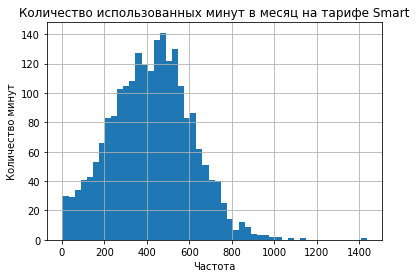

In [ ]:
plt.title('Количество использованных минут в месяц на тарифе Smart')
plt.xlabel('Частота')
plt.ylabel('Количество минут')
display(dfr[dfr['tariff'] == 'smart']['call_minutes'].describe())
print(f"Дисперсия: {dfr[dfr['tariff'] == 'smart']['call_minutes'].var()}")
dfr[dfr['tariff'] == 'smart']['call_minutes'].hist(bins=50);

График похож на распределение Пуассона. Среднее значение - 419 минут, медиана 423 минуты. Среднеквадратичное отклонение - 188.9, дисперсия - 35718.

count     947.000000
mean      547.755016
std       305.513385
min         1.000000
25%       311.000000
50%       529.000000
75%       758.000000
max      1673.000000
Name: call_minutes, dtype: float64

Дисперсия: 93338.42829141095


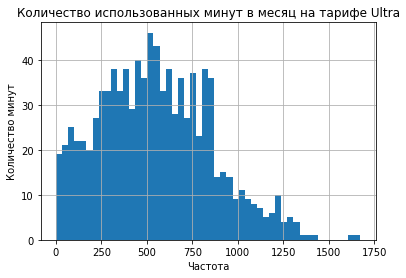

In [ ]:
plt.title('Количество использованных минут в месяц на тарифе Ultra')
plt.xlabel('Частота')
plt.ylabel('Количество минут')
display(dfr[dfr['tariff'] == 'ultra']['call_minutes'].describe())
print(f"Дисперсия: {dfr[dfr['tariff'] == 'ultra']['call_minutes'].var()}")
dfr[dfr['tariff'] == 'ultra']['call_minutes'].hist(bins=50);

Среднее значение - 547 минут, медиана 529, дисперсия - 93338.4 минуты, среднеквадратичное отклонение - 305 минут. Кажется, на тарифе Ultra в среднем тратят больше минут. Датасет скошен вправо. Чуть позже проверим, является ли эта разница статистически значимой.

count     2227.000000
mean     16243.763359
std       5860.041941
min        202.000000
25%      12677.000000
50%      16533.000000
75%      20068.000000
max      38610.000000
Name: mb_used, dtype: float64

Дисперсия: 34340091.55358943


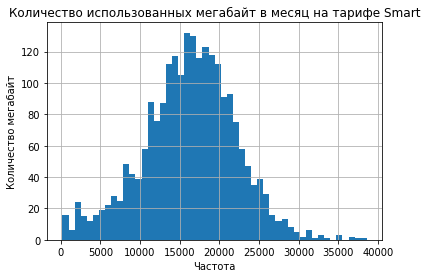

In [ ]:
plt.title('Количество использованных мегабайт в месяц на тарифе Smart')
plt.xlabel('Частота')
plt.ylabel('Количество мегабайт')
display(dfr[dfr['tariff'] == 'smart']['mb_used'].describe())
print(f"Дисперсия: {dfr[dfr['tariff'] == 'smart']['mb_used'].var()}")
dfr[dfr['tariff'] == 'smart']['mb_used'].hist(bins=50);

В среднем пользователи тарифа Smart тратят 16243 мегабайт в месяц. Медиана чуть больше - 16533 мегабайта. Среднеквадратичное отклонение - 5868. Дисперсия - 34340091. На графике видим нормальное распределение.

count      974.000000
mean     19706.979466
std       9937.127298
min        366.000000
25%      12073.750000
50%      19427.500000
75%      26936.250000
max      49789.000000
Name: mb_used, dtype: float64

Дисперсия: 98746498.93277423


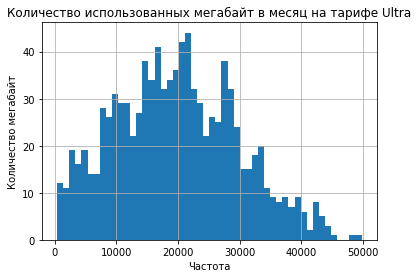

In [ ]:
plt.title('Количество использованных мегабайт в месяц на тарифе Ultra')
plt.xlabel('Частота')
plt.ylabel('Количество мегабайт')
display(dfr[dfr['tariff'] == 'ultra']['mb_used'].describe())
print(f"Дисперсия: {dfr[dfr['tariff'] == 'ultra']['mb_used'].var()}")
dfr[dfr['tariff'] == 'ultra']['mb_used'].hist(bins=50);

На тарифе Ultra абоненты в среднем используют 19706 мегабайт в месяц, медиана чуть меньше - 19427 мегабайт в месяц, - это больше, чем на тарифе Smart. Среднеквадратичное отклонение - 9937, дисперсия - 98746498. Датасет скошен вправо.

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: message_count, dtype: float64

Дисперсия: 717.5942011753547


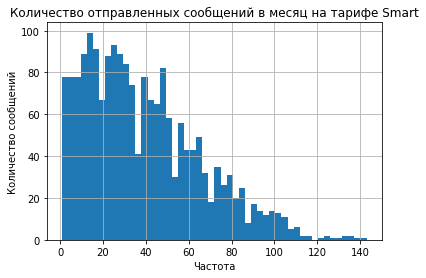

In [ ]:
plt.title('Количество отправленных сообщений в месяц на тарифе Smart')
plt.xlabel('Частота')
plt.ylabel('Количество сообщений')
display(dfr[dfr['tariff'] == 'smart']['message_count'].describe())
print(f"Дисперсия: {dfr[dfr['tariff'] == 'smart']['message_count'].var()}")
dfr[dfr['tariff'] == 'smart']['message_count'].hist(bins=50);

Распределение похоже на распределение Пуассона. Датасет скошен вправо. В среднем абонент тарифа Smart отправляет 38.7 сообщений в месяц. Медиана ниже - 34 сообщения. Дисперсия - 717, среднеквадратичное отклонение - 26.7.

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: message_count, dtype: float64

Медиана: 51.0
Дисперсия: 2109.6591828651995


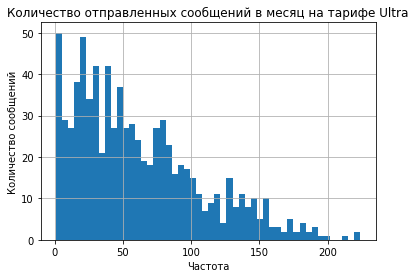

In [ ]:
plt.title('Количество отправленных сообщений в месяц на тарифе Ultra')
plt.xlabel('Частота')
plt.ylabel('Количество сообщений')
display(dfr[dfr['tariff'] == 'ultra']['message_count'].describe())
print(f"Медиана: {dfr[dfr['tariff'] == 'ultra']['message_count'].median()}")
print(f"Дисперсия: {dfr[dfr['tariff'] == 'ultra']['message_count'].var()}")
dfr[dfr['tariff'] == 'ultra']['message_count'].hist(bins=50);


Распределение похоже на распределение Пуассона. Датасет скошен вправо. В среднем абонент тарифа Ultra отправлял 61 сообщение. Медиана значительно ниже - 51 сообщение. Среднеквадратичное отклонение - 45.9, дисперсия - 2109. Как видим, на тарифе Ultra не только в среднем посылают больше сообщение, но и вариативность по оптравленным сообщениям существенно выше, чем на тарифе Smart.

In [ ]:
display(dfr[dfr['tariff'] == 'smart']['revenue'].describe())
display(dfr[dfr['tariff'] == 'ultra']['revenue'].describe())

count    2229.000000
mean     1294.639300
std       820.933202
min       550.000000
25%       550.000000
50%      1038.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64

count     985.000000
mean     2071.065990
std       378.802377
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64

Клиенты на тарифе Smart приносят в среднем 1294 рубля, Ultra - 2071 рубль.

Итоги: 

Клиенты на тарифе Ultra тратят на 20-40% больше минут, сообщений и трафика. Клиенты на тарифе Ultra приносят примерно на 50% больше денег, нежели клиенты на тарифе Smart. Проверим, являются ли наши наблюдения статистически значимыми.

### Проверка гипотез

Проверим гипотезу, что выручка от абонентов на тарифах Smart и Ultra - значимо различается. Нулевая гипотеза - месячная выручка от абонентов на тарифах Smart и Ultra не различается. Альтернативная гипотеза - месячная выручка от абонентов на тарифах Smart и Ultra различается. Возьмем пороговое значение alpha = 0.05. В качестве теста возьмем st.ttest_ind, так как размер выборки значительн больше 50, поэтому тест на нормальность по ЦПТ проводить не нужно.

In [ ]:
alpha = 0.05

results = st.ttest_ind(
    dfr[dfr['tariff'] == 'smart']['revenue'], 
    dfr[dfr['tariff'] == 'ultra']['revenue'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.7240946993530846e-246
Отвергаем нулевую гипотезу


Значение p - мизерное, с высочайшей долей вероятности мы можем отвергнуть нулевую гипотезу. Можем утверждать, что выручка от пользователей на тарифах Smart и Ultra значимо отличается.

In [ ]:
dfr = dfr.merge(df5[['user_id', 'city']], on='user_id', how='left')
display(dfr[dfr['city'] == 'Москва']['revenue'].describe())
display(dfr[dfr['city'] != 'Москва']['revenue'].describe())

count     611.000000
mean     1550.805237
std       752.451347
min       550.000000
25%       798.000000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue, dtype: float64

count    2603.000000
mean     1528.316942
std       810.411374
min       550.000000
25%       750.000000
50%      1587.000000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

Стандартные отклонения выборок отличаются более чем на 5%, поэтому в тесте ttest_ind будем использовать equal_var = False. Проверим гипотезу, что выручка от абонентов из Москвы и остальных регионов - значимо различается. Нулевая гипотеза - месячная выручка от абонентов из Москвы и регионов не различается. Альтернативная гипотеза - месячная выручка от абонентов из Москвы и регионов различается. Возьмем пороговое значение alpha = 0.05. В качестве теста возьмем st.ttest_ind, чтобы сравнить среднее двух генеральных совокупностей.

In [ ]:
alpha = 0.05

results = st.ttest_ind(
    dfr[dfr['city'] == 'Москва']['revenue'], 
    dfr[dfr['city'] != 'Москва']['revenue'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5126564657748214
Не получилось отвергнуть нулевую гипотезу


Аналогичную гипотезу для пользователей из Москвы и других городов отвергнуть не удалось. Разница между выручкой от абонентов из Москвы и регионов можно признать статистически не значимой.

### Выводы

- Клиенты на тарифе Ultra приносят больше денег. В рекламной кампании нужно сделать упор на него.

- Клиенты на тарифе Smart приносят в среднем 1294 рубля, Ultra - 2071 рубля в месяц. Эта разница статистически значима.

- Не удалось найти подтверждений, что разница между месячной выручкой, которые приносят жители Москвы, от жителей других регионов страны, - статистически значима.

- Данные без пропусков. Поменяли типы столбцов с датами, удалили строки с нулевыми значениями длительности звонков (пропущенные вызовы или исходящие). Аномалий в данных не выявлено.

- В среднем абоненты говорят 419 минут в месяц на тарифе Smart и 547 минут в месяц на тарифе Ultra.

- В среднем абоненты на тарифе Smart отправляют 39 сообщений в месяц, на Ultra - 61.

- В среднем абоненты на тарифе Smart используют 16236 мегабайт в месяц, на Ultra - 19686 мегабайт в месяц.